# Background 
This notebooks aims to study and visualise global views of climate change in light of COVID-19 pandemic, these views are scraped from twitter to capture the public's reaction through 2021 with the focus on the hashtags #climatechange and #COVID

# Importing relevant libraries 

In [364]:
#Importing Libraries

#Twitter Scraping and Data
from tqdm.auto import tqdm
import snscrape.modules.twitter as sntwitter
from snscrape.base import ScraperException
import json
import nltk
import pandas as pd
import numpy as np
import mysql.connector

#Sentiment Analysis
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
import datetime as dt


#Data Visualisation
from wordcloud import WordCloud
from collections import Counter
from PIL import Image
import re
import string

import matplotlib.pyplot as plt
plt.style.use('seaborn')
import seaborn as sns

# Scraping tweets

In [6]:
#scraping twitter during specific time period and with #climatechange as keyword and only english tweets
%%time

cc_tweets = []
for i, tweet in tqdm(enumerate(sntwitter.TwitterSearchScraper('(#climatechange) lan:eng since:2021-01-01 until:2021-12-09').get_items())):
    try:
        cc_tweets.append([tweet.date,
                          tweet.id,
                          tweet.content,
                          tweet.replyCount,
                          tweet.retweetCount,
                          tweet.likeCount,
                          tweet.coordinates])
    except ScraperException:
        print('Scraper Exception... continuing')
        continue

CPU times: user 5 µs, sys: 1e+03 ns, total: 6 µs
Wall time: 12.2 µs


0it [00:01, ?it/s]


In [ ]:
# Creating a dataframe from the tweets list above
cc_tweets_df = pd.DataFrame(cc_tweets, columns=['date', 'tweet_id', 'text', 'replies', 'retweets', 'likes', 'place'])

In [174]:
#raw scraped data
cc_tweets_df

,date,tweet_id,text,replies,retweets,likes,place
0,2021-12-08 23:59:56+00:00,1.468732e+18,Is Meat Really that Bad? [Yes.] https://t.co/A...,0.0,1.0,0.0,NaN
1,2021-12-08 23:59:01+00:00,1.468732e+18,@samanthamaiden @GladysB Not surprising though...,1.0,9.0,11.0,NaN
2,2021-12-08 23:58:00+00:00,1.468732e+18,"@TheRACP climate change report, co-authored by...",0.0,4.0,4.0,NaN
3,2021-12-08 23:57:34+00:00,1.468732e+18,The Paris Agreement: knowledge management and ...,0.0,0.0,0.0,NaN
4,2021-12-08 23:57:28+00:00,1.468731e+18,The Paris Agreement: knowledge management and ...,0.0,0.0,0.0,NaN
...,...,...,...,...,...,...,...
1102328,2021-01-01 00:01:03+00:00,1.344796e+18,Jax Brewery (The Katrina Portraits 3)\nhttps:/...,0.0,3.0,2.0,NaN
1102329,2021-01-01 00:00:43+00:00,1.344796e+18,Carriageway (The Katrina Portraits 4)\nhttps:/...,0.0,2.0,3.0,NaN
1102330,2021-01-01 00:00:22+00:00,1.344796e+18,Marigny Triangle (The Katrina Portraits 5)\nht...,0.0,1.0,1.0,NaN
1102331,2021-01-01 00:00:03+00:00,1.344795e+18,If you’re thinking of making a “green” New Yea...,0.0,0.0,1.0,NaN


In [131]:
#storing dataframe of scraped tweets in a csv file 
#cc_tweets_df.to_csv('climatechange_final.csv', index=False)

In [ ]:
#scraping twitter during specific time period and with #covid or #covid-19 as keywords and only english tweets
%time

covid_tweets = []
for i, tweet in tqdm(enumerate(sntwitter.TwitterSearchScraper('(#covid OR #covid-19) lang:en since:2021-01-01 until:2021-12-09').get_items())):
    try:
        covid_tweets.append([tweet.date,
                          tweet.id,
                          tweet.content,
                          tweet.replyCount,
                          tweet.retweetCount,
                          tweet.likeCount,
                          tweet.coordinates])
    except ScraperException:
        print('Scraper Exception... continuing')
        continue

In [ ]:
# Creating a dataframe from the tweets list above
covid_tweets_df = pd.DataFrame(covid_tweets, columns=['date', 'tweet_id', 'text', 'replies', 'retweets', 'likes', 'place'])

In [11]:
covid_tweets_df

,date,tweet_id,text,replies,retweets,likes,place
0,2021-12-08 23:59:56+00:00,1468732107719651329,"@LeftEye16 Kia ora, a map of locations of inte...",1,0,0,None
1,2021-12-08 23:59:53+00:00,1468732093014310916,NOPE‼️ You cannot count the jobs that were los...,0,0,0,None
2,2021-12-08 23:59:50+00:00,1468732082172178435,An increasing number of workplaces across Aust...,0,0,0,None
3,2021-12-08 23:59:49+00:00,1468732075343851523,Final lecture of my course on Analytical Found...,0,0,12,None
4,2021-12-08 23:59:43+00:00,1468732051708805124,@recneps51 What's a self respecting virus doin...,0,0,1,None
...,...,...,...,...,...,...,...
598298,2021-11-26 00:51:51+00:00,1464034130878894106,COVID-19: Saudi Arabia to lift entry ban from ...,1,1,21,None
598299,2021-11-26 00:51:50+00:00,1464034125342515206,REPORT: Get Ready For Hysteria Over The New #B...,14,30,42,None
598300,2021-11-26 00:51:48+00:00,1464034117964779520,@leanneelford @JeanneGirvan @Cath_Tyldesley Yo...,2,0,1,None
598301,2021-11-26 00:51:40+00:00,1464034084808806400,@elemare @Dai_Watson @ChanceTyColeman I agree ...,1,0,1,None


In [10]:
#storing dataframe of scraped tweets in a csv file 
#covid_tweets_df.to_csv("covid_2nd.csv", index=False)

# First impression of raw data

In [365]:
#loading climate change tweets csv file 
cc_tweets_df = pd.read_csv ('climatechange_final.csv')

/opt/anaconda3/envs/DA_env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (0,2,6) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [366]:
#loading covid tweets csv file 
covid_tweets_df = pd.read_csv('covid_2nd.csv',
                 lineterminator='\n')

In [367]:
#data types climate change tweets 
cc_tweets_df.dtypes

date         object
tweet_id    float64
text         object
replies     float64
retweets    float64
likes       float64
place        object
dtype: object

In [368]:
#data types COVID tweets 
covid_tweets_df.dtypes

date        object
tweet_id     int64
text        object
replies      int64
retweets     int64
likes        int64
place       object
dtype: object

In [369]:
#checking nan values in each column (CC)
cc_tweets_df.isna().sum()

date         131072
tweet_id     131079
text         131079
replies      227920
retweets     227930
likes        227930
place       1085197
dtype: int64

In [14]:
#checking values in each column (Covid)
covid_tweets_df.isna().sum()

date             0
tweet_id         0
text             0
replies          0
retweets         0
likes            0
place       589379
dtype: int64

# Defining functions for pre-processing


## Filtering non english tweets

## Changing data types

In [388]:
#changing date type to datetime and dropping the time
def date_type(df):
    
    #change type
    df['date']=pd.to_datetime(df['date'], errors='coerce')
    #extracting the date only
    df["date"] = df["date"].dt.date

## Dropping duplicates

In [370]:
#checking for the number of duplicate tweets
def count_duplicated_tweets(df):
    return cc_tweets_df.duplicated(subset='text').sum()

#dropping duplicate tweets inplace 
def duplicate_tweets_drop(df):
    df_duplicates_free=df.drop_duplicates(subset= ['text'], inplace=True)
    return df_duplicates_free

## Dealing with missing values

In [371]:
#checking the number of missing values 
def count_na_values(df):
    null_count=df.isna().sum()
    return null_count

In [372]:
#dropping Nan values- excluding place column
def na_drop(df):
    df_na_free= df.dropna(subset=['date', 'tweet_id', 'text', 'replies', 'retweets', 'likes'], inplace=True)
    return df_na_free

## Removing links & Mentions (URLs & @s)

In [21]:
#removing URL links and mentions in tweets
def remove_usernames_links(tweet):
    # Remove any hyperlinks that may be in the text starting with http
    tweet = re.sub('@[^\s]+','',str(tweet))
    tweet = re.sub('http[^\s]+','',str(tweet))
    return tweet

## Removing stopwords

In [373]:
#downloading english stopwords
stop_words=stopwords.words('english')

#function for removing stopwords from tweets
def remove_stopwords(df):
    df['text'] = df['text'].apply(lambda x: ' '.join([item for item in x.split() if item not in stop_words]))

# Data pre-processing

In [ ]:
# Climate change dataset
date_type(cc_tweets_df)

count_duplicated_tweets(cc_tweets_df)
duplicate_tweets_drop(cc_tweets_df)

count_na_values(cc_tweets_df)
na_drop(cc_tweets_df)

#removing URLs and mentions only in tweets i.e. "text" column
cc_tweets_df['text'] = cc_tweets_df['text'].apply(remove_usernames_links)

#downloading english stopwords
stop_words=stopwords.words('english')
remove_stopwords(cc_tweets_df)

In [375]:
#check climate change clean data size
cc_tweets_df.shape

(839498, 7)

In [376]:
# Covid dataset, although the dataset is clean we ran all the functions for data pre-processing
#date_type(covid_tweets_df)

count_duplicated_tweets(covid_tweets_df)
duplicate_tweets_drop(covid_tweets_df)

count_na_values(covid_tweets_df)
na_drop(covid_tweets_df)

#removing URLs and mentions only in tweets i.e. "text" column
covid_tweets_df['text'] = covid_tweets_df['text'].apply(remove_usernames_links)

#downloading english stopwords
stop_words=stopwords.words('english')
remove_stopwords(covid_tweets_df)

#removing URLs and mentions only in tweets i.e. "text" column
covid_tweets_df['text'] = covid_tweets_df['text'].apply(remove_usernames_links)


#downloading english stopwords
stop_words=stopwords.words('english')
remove_stopwords(covid_tweets_df)

In [183]:
#check COVID clean data size
covid_tweets_df.shape

(478836, 13)

# Identifying sentiment using VADAR package

## Defining functions 

In [377]:
analyzer = SentimentIntensityAnalyzer()

# getting only the negative score
def negative_score(text):
    negative_value = analyzer.polarity_scores(text)['neg']
    return negative_value

# getting only the neutral score
def neutral_score(text):
    neutral_value = analyzer.polarity_scores(text)['neu']
    return neutral_value

# getting only the positive score
def positive_score(text):
    positive_value = analyzer.polarity_scores(text)['pos']
    return positive_value

# getting only the compound score
def compound_score(text):
    compound_value = analyzer.polarity_scores(text)['compound']
    return compound_value

## Sentiment Analysis (Climate Change)

In [378]:
%%time
#applying sentiment scoring functions and adding new columns with resulting score
cc_tweets_df['sen_negative'] = cc_tweets_df['text'].apply(negative_score)
cc_tweets_df['sen_neutral'] = cc_tweets_df['text'].apply(neutral_score)
cc_tweets_df['sen_positive'] = cc_tweets_df['text'].apply(positive_score)
cc_tweets_df['sen_compound'] = cc_tweets_df['text'].apply(compound_score)

CPU times: user 5min, sys: 1.37 s, total: 5min 2s
Wall time: 5min 3s


In [50]:
cc_tweets_df.describe()

,tweet_id,replies,retweets,likes,sen_negative,sen_neutral,sen_positive,sen_compound
count,8.394980e+05,839498.000000,839498.000000,839498.000000,839498.000000,839498.000000,839498.000000,839498.000000
mean,1.410780e+18,0.438265,2.479861,6.250291,0.071864,0.806190,0.121943,0.123978
std,3.608828e+16,10.197360,42.848974,168.273829,0.109873,0.158557,0.132007,0.457809
min,1.344795e+18,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.999300
25%,1.380157e+18,0.000000,0.000000,0.000000,0.000000,0.695000,0.000000,-0.077200
50%,1.413411e+18,0.000000,0.000000,1.000000,0.000000,0.814000,0.096000,0.000000
75%,1.443469e+18,0.000000,2.000000,3.000000,0.125000,1.000000,0.205000,0.493900
max,1.468732e+18,7264.000000,31398.000000,131508.000000,0.986000,1.000000,0.914000,0.999400


In [379]:
#clean data size
cc_tweets_df.shape

(839498, 11)

## Sentiment Analysis (COVID)

In [380]:
%%time
#applying sentiment scoring functions and adding new columns with resulting score
covid_tweets_df['sen_negative'] = covid_tweets_df['text'].apply(negative_score)
covid_tweets_df['sen_neutral'] = covid_tweets_df['text'].apply(neutral_score)
covid_tweets_df['sen_positive'] = covid_tweets_df['text'].apply(positive_score)
covid_tweets_df['sen_compound'] = covid_tweets_df['text'].apply(compound_score)

CPU times: user 3min 8s, sys: 646 ms, total: 3min 9s
Wall time: 3min 9s


In [329]:
covid_tweets_df.describe()

,tweet_id,replies,retweets,likes,sen_negative,sen_neutral,sen_positive,sen_compound
count,5.907360e+05,590736.000000,590736.000000,590736.000000,590736.000000,590736.000000,590736.000000,590736.000000
mean,1.466373e+18,1.459952,3.044414,11.013009,0.090132,0.809999,0.099867,0.028632
std,1.357705e+15,23.554052,51.824091,224.273080,0.125758,0.165664,0.126106,0.446924
min,1.464034e+18,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.997100
25%,1.465294e+18,0.000000,0.000000,0.000000,0.000000,0.693000,0.000000,-0.273200
50%,1.466299e+18,0.000000,0.000000,0.000000,0.000000,0.818000,0.035000,0.000000
75%,1.467570e+18,0.000000,1.000000,2.000000,0.162000,1.000000,0.178000,0.381800
max,1.468732e+18,6630.000000,9238.000000,49607.000000,1.000000,1.000000,1.000000,0.999800


In [381]:
#clean data size
covid_tweets_df.shape

(590736, 11)

In [220]:
#storing updated dataframes in csv files
cc_tweets_df.to_csv("cc_analysis_clean.csv", index=False)
covid_tweets_df.to_csv("covid_analysis_clean.csv", index=False)

# Data Visualisation
## Using wordcloud

In [382]:
#defining plotting function
def plot_wordcloud(wordcloud, title):
    plt.figure(figsize=(12, 10))
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis("off")
    plt.title(title + ' Tweets\n', fontsize=18, fontweight='bold')
    plt.show()

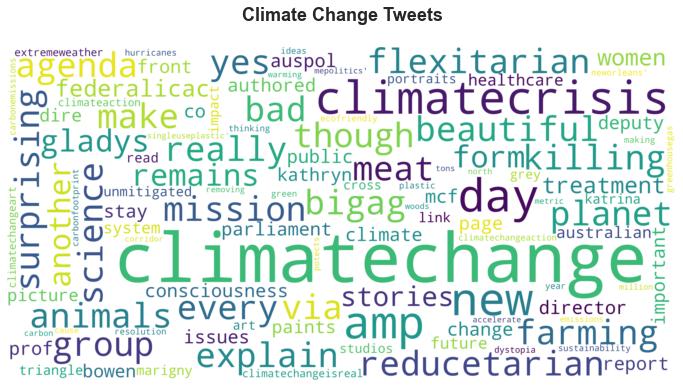

In [266]:
#using wordcould function to visualise climate change tweets 
text = (cc_tweets_df['text'].str.lower()).values
wordcloud1 = WordCloud(max_font_size=None,
                      max_words=200,
                      background_color="rgba(255, 255, 255, 0)", 
                      width=4000,
                      height=2000,
                      stopwords=stopwords.words('english')).generate(str(text))

plot_wordcloud(wordcloud, 'Climate Change')

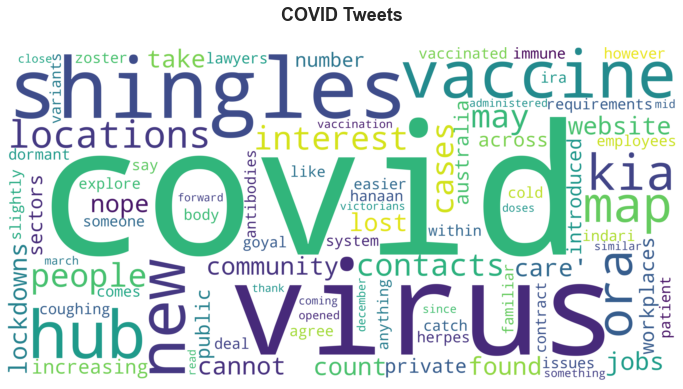

In [259]:
#using wordcould function to visualise COVID tweets 
text = (covid_tweets_df['text'].str.lower()).values
wordcloud2 = WordCloud(max_font_size=None,
                      max_words=200,
                      background_color="rgba(255, 255, 255, 0)", 
                      width=4000,
                      height=2000,
                      stopwords=stopwords.words('english')).generate(str(text))

plot_wordcloud(wordcloud, 'COVID')

In [267]:
#storing wordcloud images as png files
wordcloud1.to_file('CC.png')
wordcloud2.to_file('COVID.png')

## EDA

In [383]:
cc_tweets_df.dtypes

date             object
tweet_id        float64
text             object
replies         float64
retweets        float64
likes           float64
place            object
sen_negative    float64
sen_neutral     float64
sen_positive    float64
sen_compound    float64
dtype: object

In [384]:
#given the size of the datasets, it was grouped by date and the sum was used for EDA
def groupby_date(df):
     df.groupby(['date']).mean()   

In [405]:

pd.to_datetime(cc_tweets_df['date'], errors='coerce')

0         2021-12-08
1         2021-12-08
2         2021-12-08
3         2021-12-08
5         2021-12-08
             ...    
1102323   2021-01-01
1102326   2021-01-01
1102327   2021-01-01
1102331   2021-01-01
1102332   2021-01-01
Name: date, Length: 733341, dtype: datetime64[ns]

In [402]:
date_type(cc_tweets_df)

In [ ]:
df_date.groupby(df_date.date.dt.year)
df_date.groupby(['date']).mean()

In [394]:
groupby_date(cc_tweets_df)

In [395]:
groupby_date(covid_tweets_df)

## Histograms using Seaborn

/opt/anaconda3/envs/DA_env/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


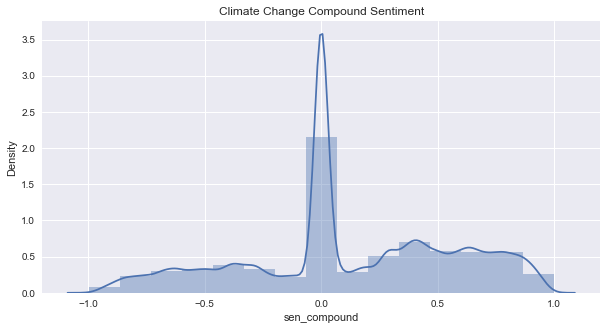

In [301]:
#quick and dirty hist of compound sentiment values (CC)
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
cc_dist=sns.distplot(cc_tweets_df['sen_compound'], bins=15, ax=ax)
plt.title('Climate Change Compound Sentiment')
plt.show()

In [304]:
#storing dist.plot image as png files
cc = cc_dist.get_figure()
cc.savefig('Climate Change Compound Sentiment',  orientation="landscape",transparent=True)

/opt/anaconda3/envs/DA_env/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


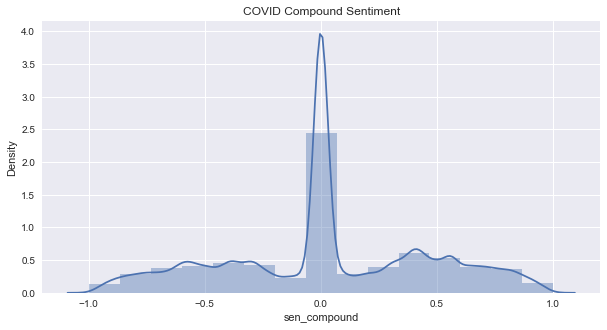

In [337]:
#quick and dirty hist of compound sentiment values (COVID)
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
covid_dist=sns.distplot(covid_tweets_df['sen_compound'], bins=15, ax=ax)
plt.title('COVID Compound Sentiment')
plt.show()

In [338]:
#storing dist.plot images as png files
covid = covid_dist.get_figure()
covid.savefig('COVID Compound Sentiment',  orientation="landscape",transparent=True)

## Time series 

In [408]:
#for ease of use, few changes were made 
def sorting_for_ploting(df):
    #sort values by date
    df.sort_values(by='date', inplace=True)
    #setting the date as index 
    df.index=df['date']
    #expanding and rolling mean were calculated
    df['mean'] = df['sen_compound'].expanding().mean()
    df['rolling'] = df['sen_compound'].rolling('6').mean()

In [413]:
cc_tweets_df["date"] = cc_tweets_df["date"].dt.date

In [415]:
cc_tweets_df['date']=pd.to_datetime(cc_tweets_df['date'], errors='coerce')

In [ ]:
sorting_for_ploting(cc_tweets_df)

In [ ]:
sorting_for_ploting(covid_tweets_df)

In [ ]:
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(111)
time=ax.scatter(cc_tweets_df['date'],cc_tweets_df['sen_compound'], label='Tweet Sentiment')
ax.plot(cc_tweets_df['date'],cc_tweets_df['rolling'], color ='r', label='Rolling Mean')
ax.plot(cc_tweets_df['date'],cc_tweets_df['mean'], color='y', label='Expanding Mean')
ax.set_xlim([dt.date(2021,1,1),dt.date(2021,12,8)])
ax.set(title='Climate Change Tweets Over Time', xlabel='Date', ylabel='Sentiment')
ax.legend(loc='best')

fig.tight_layout()
plt.show()

In [ ]:
cc = cc_dist.get_figure()
cc.savefig('Climate Change Compound Sentiment',  orientation="landscape",transparent=True)

In [ ]:
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(111)
ax.scatter(cc_tweets_df['YearMonth'],cc_tweets_df['sen_compound'], label='Tweet Sentiment')
ax.plot(cc_tweets_df['YearMonth'],cc_tweets_df['rolling'], color ='r', label='Rolling Mean')
ax.plot(cc_tweets_df['YearMonth'],cc_tweets_df['mean'], color='w', label='Expanding Mean')
ax.set_xlim([dt.date(2021,1,1),dt.date(2021,12,8)])
ax.set(title='COVID Tweets Over Time', xlabel='Date', ylabel='Sentiment')
ax.legend(loc='best')

fig.tight_layout()
plt.show()

In [419]:
cc_covid_df=pd.concat([cc_tweets_df, covid_tweets_df])
cc_covid_df.to_csv('CC_COVID_final.csv', index=False)

In [418]:
cc_covid_df.describe()

,tweet_id,replies,retweets,likes,sen_negative,sen_neutral,sen_positive,sen_compound,mean
count,1.324077e+06,1.324077e+06,1.324077e+06,1.324077e+06,1.324077e+06,1.324077e+06,1.324077e+06,1.324077e+06,1.324077e+06
mean,1.435942e+18,9.051105e-01,2.732844e+00,8.374071e+00,8.121046e-02,8.050194e-01,1.137681e-01,8.391384e-02,8.240691e-02
std,3.828020e+16,1.744568e+01,3.883184e+01,1.607065e+02,1.178856e-01,1.613218e-01,1.302427e-01,4.591067e-01,6.108315e-02
min,1.344795e+18,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-9.993000e-01,-1.421000e-01
25%,1.408331e+18,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.920000e-01,0.000000e+00,-2.023000e-01,2.103147e-02
50%,1.457727e+18,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,8.120000e-01,8.500000e-02,0.000000e+00,1.247396e-01
75%,1.466123e+18,0.000000e+00,1.000000e+00,3.000000e+00,1.430000e-01,1.000000e+00,1.960000e-01,4.404000e-01,1.392681e-01
max,1.468732e+18,7.264000e+03,1.003500e+04,4.960700e+04,1.000000e+00,1.000000e+00,1.000000e+00,9.998000e-01,6.173500e-01


In [307]:
cc_covid_df._get_numeric_data()
numerical=cc_covid_df.drop(['date', 'text','place', 'tweet_id'], axis=1)

In [339]:
cc_tweets_df

,date,tweet_id,text,replies,retweets,likes,place,sen_negative,sen_neutral,sen_positive,sen_compound,YearMonth
0,2021-12-08,1.468732e+18,Is Meat Really Bad? [Yes.] via This group's mi...,0.0,1.0,0.0,NaN,0.287,0.524,0.190,-0.5446,2021-12
1,2021-12-08,1.468732e+18,Not surprising though. Every day #Gladys remai...,1.0,9.0,11.0,NaN,0.059,0.882,0.059,-0.0036,2021-12
2,2021-12-08,1.468732e+18,"climate change report, co-authored MCF Deputy ...",0.0,4.0,4.0,NaN,0.125,0.875,0.000,-0.4588,2021-12
3,2021-12-08,1.468732e+18,The Paris Agreement: knowledge management clim...,0.0,0.0,0.0,NaN,0.000,0.738,0.262,0.4939,2021-12
4,2021-12-08,1.468731e+18,The Paris Agreement: knowledge management clim...,0.0,0.0,0.0,NaN,0.000,0.738,0.262,0.4939,2021-12
...,...,...,...,...,...,...,...,...,...,...,...,...
1102328,2021-01-01,1.344796e+18,Jax Brewery (The Katrina Portraits 3) Grey Cro...,0.0,3.0,2.0,NaN,0.000,0.938,0.062,0.0516,2021-1
1102329,2021-01-01,1.344796e+18,Carriageway (The Katrina Portraits 4) Grey Cro...,0.0,2.0,3.0,NaN,0.000,0.934,0.066,0.0516,2021-1
1102330,2021-01-01,1.344796e+18,Marigny Triangle (The Katrina Portraits 5) Gre...,0.0,1.0,1.0,NaN,0.000,0.938,0.062,0.0516,2021-1
1102331,2021-01-01,1.344795e+18,If you’re thinking making “green” New Year’s r...,0.0,0.0,1.0,NaN,0.000,1.000,0.000,0.0000,2021-1


In [324]:
#without neural 
extremes= cc_tweets_df.drop('sen_neutral', axis=1)

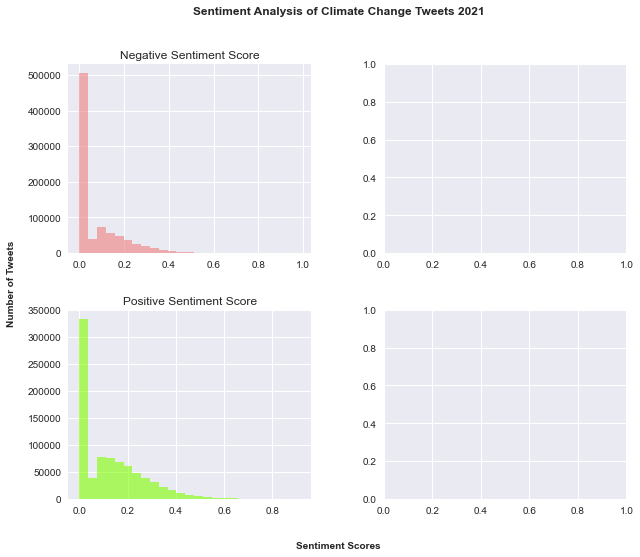

In [326]:


# all scores in 4 histograms
fig, axes = plt.subplots(2, 2, figsize=(10,8))

# plot all 4 histograms
extremes.hist('sen_negative', bins=25, ax=axes[0,0], color='lightcoral', alpha=0.6)
axes[0,0].set_title('Negative Sentiment Score')

#cc_tweets_df.hist('sen_neutral', bins=25, ax=axes[0,1], color='lightsteelblue', alpha=0.6)
#axes[0,1].set_title('Neutral Sentiment Score')

extremes.hist('sen_positive', bins=25, ax=axes[1,0], color='chartreuse', alpha=0.6)
axes[1,0].set_title('Positive Sentiment Score')

#extremes.hist('sen_compound', bins=25, ax=axes[1,1], color='navajowhite', alpha=0.6)
#axes[1,1].set_title('Compound')

# plot common x- and y-label
fig.text(0.5, 0.04, 'Sentiment Scores',  fontweight='bold', ha='center')
fig.text(0.04, 0.5, 'Number of Tweets', fontweight='bold', va='center', rotation='vertical')

# plot title
plt.suptitle('Sentiment Analysis of Climate Change Tweets 2021\n\n', fontsize=12, fontweight='bold');

Text(0.5, 1.0, 'Heatmap of Climate Change & COVID Tweets')

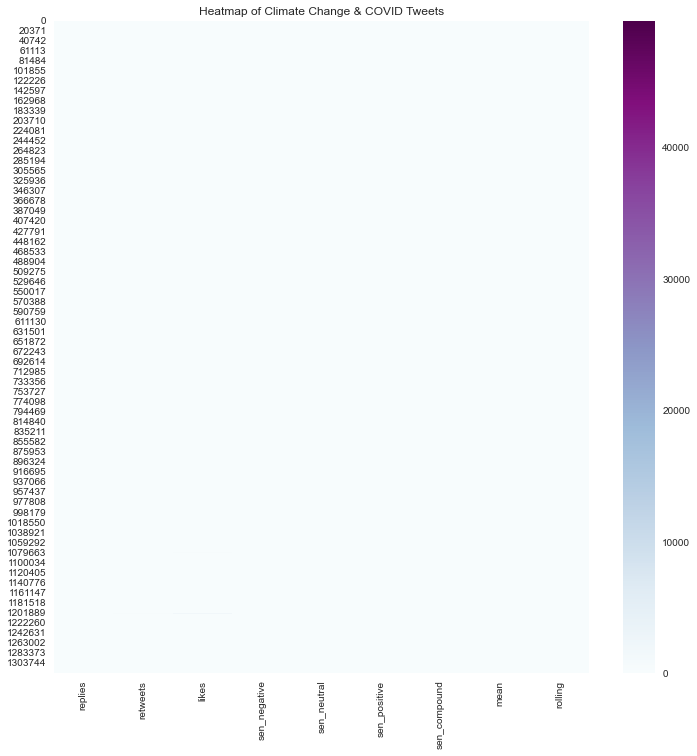

In [311]:
fig = plt.figure(figsize=(12,12))
r = sns.heatmap(numerical, cmap='BuPu')
r.set_title("Heatmap of Climate Change & COVID Tweets")

In [310]:
numerical.reset_index(drop=True, inplace=True)